Домашнее задание

    Добиться хорошего результата от модели, собранной на занятии (5 угаданныx картинок из 8 предложенных). Варианты изменений:

    изменение слоёв и их количества;
    изменение метода оптимизации;
    изменение процесса обучения;
    *преобразование данных transform


In [1]:
import torch
from torch import nn
from torch import optim

import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_dataset = torchvision.datasets.CIFAR10(
                  root='data/',  
                  train=True,      
                  transform=transforms.ToTensor(), 
                  download=True, 
                  )

train_dataset

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data/


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: data/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [3]:
image, label = train_dataset[0]
print(image.size())
print(label)

torch.Size([3, 32, 32])
6


In [4]:
image.permute(1, 2, 0).shape

torch.Size([32, 32, 3])

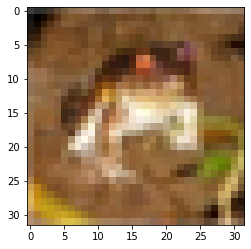

In [9]:
plt.imshow(image.permute(1, 2, 0).numpy());

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=64, 
                                           shuffle=True)

In [11]:
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            download=True, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8,
                                          shuffle=False)

Files already downloaded and verified


In [12]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

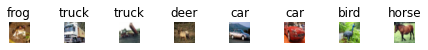

In [15]:
#визуализируем классы
fig = plt.figure()

for i in range(8):
    image = train_dataset[i][0]
    label = train_dataset[i][1]
    
    ax = plt.subplot(1, 8, i+1)
    plt.tight_layout()
    ax.set_title(f'{classes[label]}')
    ax.axis('off')
    image = plt.imshow(image.permute(1, 2, 0).numpy())
        
    if i == 8:
        plt.show()
        break

In [29]:
#модель
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 4 * hidden_dim)
        self.fc2 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc3 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.softmax(x)
        return x

In [30]:
#инициализация модели
net = Net(3072, 100, 10)  #входной вектор 3*32*32 = 3072, выход 10 классов

In [31]:
#компиляция
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0)

In [32]:
#обучение модели
net.train()
num_epochs = 5

for epoch in range(num_epochs):
    #текущее значение функции потерь
    running_loss = 0.0
    running_items = 0.0

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1] # входные данные с лейблами
        # Обнуляем градиент
        optimizer.zero_grad()
        # Делаем предсказание
        outputs = net(inputs)
        # Рассчитываем лосс-функцию (функцию потерь)
        loss = criterion(outputs, labels)
        # Вычисляем градиент
        loss.backward()
        # Обновляем веса (делаем шаг оптимайзера)
        optimizer.step()
        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}')
            running_loss, running_items = 0.0, 0.0

print('Training is finished!')

Epoch [1/5]. Step [1/782]. Loss: 0.036
Epoch [1/5]. Step [301/782]. Loss: 0.036
Epoch [1/5]. Step [601/782]. Loss: 0.035
Epoch [2/5]. Step [1/782]. Loss: 0.034
Epoch [2/5]. Step [301/782]. Loss: 0.032
Epoch [2/5]. Step [601/782]. Loss: 0.031
Epoch [3/5]. Step [1/782]. Loss: 0.029
Epoch [3/5]. Step [301/782]. Loss: 0.030
Epoch [3/5]. Step [601/782]. Loss: 0.030
Epoch [4/5]. Step [1/782]. Loss: 0.026
Epoch [4/5]. Step [301/782]. Loss: 0.029
Epoch [4/5]. Step [601/782]. Loss: 0.029
Epoch [5/5]. Step [1/782]. Loss: 0.029
Epoch [5/5]. Step [301/782]. Loss: 0.028
Epoch [5/5]. Step [601/782]. Loss: 0.028
Training is finished!


Тестируем текущую модель

GroundTruth:  cat ship ship plane frog frog car frog


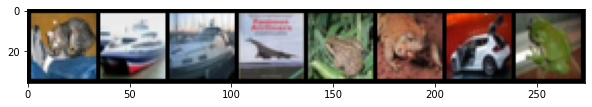

In [33]:
# Изображения из тестового набора
dataiter = iter(test_loader)
images, labels = dataiter.next()

imgs = torchvision.utils.make_grid(images)

plt.figure(figsize=(10, 5))
plt.imshow(imgs.permute(1, 2, 0).numpy())
print('GroundTruth: ', ' '.join(classes[labels[j]] for j in range(len(labels))))

In [34]:
# предсказание модели
net.eval()
outputs = net(images)

# получение предсказания название класса
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(classes[predicted[j]] for j in range(len(labels))))

Predicted:  dog truck ship ship deer frog cat deer


In [35]:
gt = np.array([classes[labels[j]] for j in range(len(labels))])
pred = np.array([classes[predicted[j]] for j in range(len(labels))])

print(gt)
print(pred)
print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['dog' 'truck' 'ship' 'ship' 'deer' 'frog' 'cat' 'deer']
Accuracy is 0.25


Изменяем модель

In [23]:
def model_testing(num_epochs, train_loader, test_loader, model, criterion, optimizer):
    #обучение модели
    model.train()
    for epoch in range(num_epochs):
    #текущее значение функции потерь
        running_loss = 0.0
        running_items = 0.0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data[0], data[1] # входные данные с лейблами
            # Обнуляем градиент
            optimizer.zero_grad()
            # Делаем предсказание
            outputs = model(inputs)
            # Рассчитываем лосс-функцию (функцию потерь)
            loss = criterion(outputs, labels)
            # Вычисляем градиент
            loss.backward()
            # Обновляем веса (делаем шаг оптимайзера)
            optimizer.step()
            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            if i % 300 == 0:    # печатаем каждые 300 mini-batches
                print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                      f'Step [{i + 1}/{len(train_loader)}]. ' \
                      f'Loss: {running_loss / running_items:.3f}')
                running_loss, running_items = 0.0, 0.0

    print('Training is finished!')
    
    model.eval()
    # Изображения из тестового набора
    dataiter = iter(test_loader)
    images, labels = dataiter.next()

    # предсказание модели
    outputs = model(images)
    imgs = torchvision.utils.make_grid(images)

    plt.figure(figsize=(10, 5))
    plt.imshow(imgs.permute(1, 2, 0).numpy())
    print('Test classes: ', ' '.join(classes[labels[j]] for j in range(len(labels))))
    
    # получение предсказания название класса
    _, predicted = torch.max(outputs, 1)

    gt = np.array([classes[labels[j]] for j in range(len(labels))])
    pred = np.array([classes[predicted[j]] for j in range(len(labels))])

    print(gt)
    print(pred)
    print(f'Accuracy is {(gt == pred).sum() / len(gt)}')

Начнем с изменения количества слоев

In [36]:
class Net_6_layers(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 16 * hidden_dim)
        self.fc2 = nn.Linear(16 * hidden_dim, 8 * hidden_dim)
        self.fc3 = nn.Linear(8 * hidden_dim, 4 * hidden_dim)
        self.fc4 = nn.Linear(4 * hidden_dim, 2 * hidden_dim)
        self.fc5 = nn.Linear(2 * hidden_dim, hidden_dim)
        self.fc6 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.leaky_relu(x)
        x = self.fc5(x)
        x = F.leaky_relu(x)
        x = self.fc6(x)
        return x
    
    def predict(self, x):
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        x = F.leaky_relu(x)
        x = self.fc4(x)
        x = F.leaky_relu(x)
        x = self.fc5(x)
        x = F.leaky_relu(x)
        x = self.fc6(x)
        x = F.softmax(x)
        return x

Epoch [1/5]. Step [1/782]. Loss: 0.036
Epoch [1/5]. Step [301/782]. Loss: 0.036
Epoch [1/5]. Step [601/782]. Loss: 0.036
Epoch [2/5]. Step [1/782]. Loss: 0.036
Epoch [2/5]. Step [301/782]. Loss: 0.036
Epoch [2/5]. Step [601/782]. Loss: 0.036
Epoch [3/5]. Step [1/782]. Loss: 0.036
Epoch [3/5]. Step [301/782]. Loss: 0.035
Epoch [3/5]. Step [601/782]. Loss: 0.034
Epoch [4/5]. Step [1/782]. Loss: 0.033
Epoch [4/5]. Step [301/782]. Loss: 0.032
Epoch [4/5]. Step [601/782]. Loss: 0.032
Epoch [5/5]. Step [1/782]. Loss: 0.032
Epoch [5/5]. Step [301/782]. Loss: 0.031
Epoch [5/5]. Step [601/782]. Loss: 0.031
Training is finished!
Test classes:  cat ship ship plane frog frog car frog
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['horse' 'truck' 'ship' 'ship' 'frog' 'frog' 'frog' 'frog']
Accuracy is 0.5


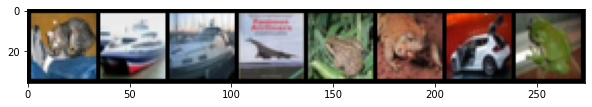

In [37]:
num_epochs = 5
train_loader = train_loader
test_loader = test_loader
model = Net_6_layers(3072, 100, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

model_testing(num_epochs, train_loader, test_loader, model, criterion, optimizer)

Увеличение количества слоев дает улучшение метрики

Вернемся к предыдущей модели и увеличим количество эпох

Epoch [1/20]. Step [1/782]. Loss: 0.036
Epoch [1/20]. Step [301/782]. Loss: 0.036
Epoch [1/20]. Step [601/782]. Loss: 0.035
Epoch [2/20]. Step [1/782]. Loss: 0.032
Epoch [2/20]. Step [301/782]. Loss: 0.032
Epoch [2/20]. Step [601/782]. Loss: 0.031
Epoch [3/20]. Step [1/782]. Loss: 0.031
Epoch [3/20]. Step [301/782]. Loss: 0.030
Epoch [3/20]. Step [601/782]. Loss: 0.030
Epoch [4/20]. Step [1/782]. Loss: 0.030
Epoch [4/20]. Step [301/782]. Loss: 0.029
Epoch [4/20]. Step [601/782]. Loss: 0.029
Epoch [5/20]. Step [1/782]. Loss: 0.027
Epoch [5/20]. Step [301/782]. Loss: 0.028
Epoch [5/20]. Step [601/782]. Loss: 0.028
Epoch [6/20]. Step [1/782]. Loss: 0.027
Epoch [6/20]. Step [301/782]. Loss: 0.027
Epoch [6/20]. Step [601/782]. Loss: 0.027
Epoch [7/20]. Step [1/782]. Loss: 0.029
Epoch [7/20]. Step [301/782]. Loss: 0.027
Epoch [7/20]. Step [601/782]. Loss: 0.026
Epoch [8/20]. Step [1/782]. Loss: 0.031
Epoch [8/20]. Step [301/782]. Loss: 0.026
Epoch [8/20]. Step [601/782]. Loss: 0.026
Epoch [9

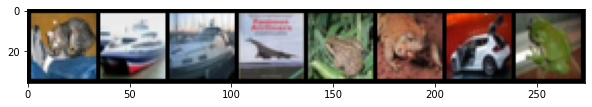

In [27]:
num_epochs = 20
train_loader = train_loader
test_loader = test_loader
model = Net(3072, 100, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

model_testing(num_epochs, train_loader, test_loader, model, criterion, optimizer)

Увеличение количества эпох улучшает метрику

Теперь попробуем увеличить количество нейронов

Epoch [1/5]. Step [1/782]. Loss: 0.036
Epoch [1/5]. Step [301/782]. Loss: 0.036
Epoch [1/5]. Step [601/782]. Loss: 0.034
Epoch [2/5]. Step [1/782]. Loss: 0.032
Epoch [2/5]. Step [301/782]. Loss: 0.032
Epoch [2/5]. Step [601/782]. Loss: 0.031
Epoch [3/5]. Step [1/782]. Loss: 0.030
Epoch [3/5]. Step [301/782]. Loss: 0.030
Epoch [3/5]. Step [601/782]. Loss: 0.029
Epoch [4/5]. Step [1/782]. Loss: 0.033
Epoch [4/5]. Step [301/782]. Loss: 0.029
Epoch [4/5]. Step [601/782]. Loss: 0.028
Epoch [5/5]. Step [1/782]. Loss: 0.030
Epoch [5/5]. Step [301/782]. Loss: 0.027
Epoch [5/5]. Step [601/782]. Loss: 0.027
Training is finished!
Test classes:  cat ship ship plane frog frog car frog
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['dog' 'ship' 'ship' 'ship' 'deer' 'frog' 'dog' 'deer']
Accuracy is 0.375


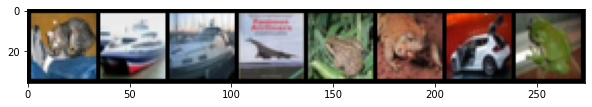

In [38]:
num_epochs = 5
train_loader = train_loader
test_loader = test_loader
model = Net(3072, 400, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)

model_testing(num_epochs, train_loader, test_loader, model, criterion, optimizer)

Увеличение числа нейронов в данном случае дало незначительное улучшение

Изменим метод оптимизации

Epoch [1/5]. Step [1/782]. Loss: 0.036
Epoch [1/5]. Step [301/782]. Loss: 0.031
Epoch [1/5]. Step [601/782]. Loss: 0.028
Epoch [2/5]. Step [1/782]. Loss: 0.028
Epoch [2/5]. Step [301/782]. Loss: 0.027
Epoch [2/5]. Step [601/782]. Loss: 0.026
Epoch [3/5]. Step [1/782]. Loss: 0.026
Epoch [3/5]. Step [301/782]. Loss: 0.025
Epoch [3/5]. Step [601/782]. Loss: 0.025
Epoch [4/5]. Step [1/782]. Loss: 0.023
Epoch [4/5]. Step [301/782]. Loss: 0.024
Epoch [4/5]. Step [601/782]. Loss: 0.024
Epoch [5/5]. Step [1/782]. Loss: 0.022
Epoch [5/5]. Step [301/782]. Loss: 0.023
Epoch [5/5]. Step [601/782]. Loss: 0.023
Training is finished!
Test classes:  cat ship ship plane frog frog car frog
['cat' 'ship' 'ship' 'plane' 'frog' 'frog' 'car' 'frog']
['cat' 'truck' 'ship' 'plane' 'deer' 'frog' 'dog' 'bird']
Accuracy is 0.5


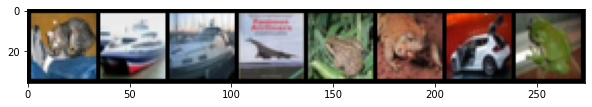

In [42]:
num_epochs = 5
train_loader = train_loader
test_loader = test_loader
model = Net(3072, 100, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_testing(num_epochs, train_loader, test_loader, model, criterion, optimizer)

Изменение метода оптимизации дало некоторое улучшение базовой метрики

Попробуем совместить некоторые улучшения и посмотрим на результаты

Epoch [1/20]. Step [1/782]. Loss: 0.036
Epoch [1/20]. Step [301/782]. Loss: 0.031
Epoch [1/20]. Step [601/782]. Loss: 0.028
Epoch [2/20]. Step [1/782]. Loss: 0.027
Epoch [2/20]. Step [301/782]. Loss: 0.026
Epoch [2/20]. Step [601/782]. Loss: 0.026
Epoch [3/20]. Step [1/782]. Loss: 0.027
Epoch [3/20]. Step [301/782]. Loss: 0.025
Epoch [3/20]. Step [601/782]. Loss: 0.025
Epoch [4/20]. Step [1/782]. Loss: 0.023
Epoch [4/20]. Step [301/782]. Loss: 0.024
Epoch [4/20]. Step [601/782]. Loss: 0.024
Epoch [5/20]. Step [1/782]. Loss: 0.023
Epoch [5/20]. Step [301/782]. Loss: 0.023
Epoch [5/20]. Step [601/782]. Loss: 0.023
Epoch [6/20]. Step [1/782]. Loss: 0.024
Epoch [6/20]. Step [301/782]. Loss: 0.022
Epoch [6/20]. Step [601/782]. Loss: 0.022
Epoch [7/20]. Step [1/782]. Loss: 0.021
Epoch [7/20]. Step [301/782]. Loss: 0.022
Epoch [7/20]. Step [601/782]. Loss: 0.022
Epoch [8/20]. Step [1/782]. Loss: 0.019
Epoch [8/20]. Step [301/782]. Loss: 0.021
Epoch [8/20]. Step [601/782]. Loss: 0.021
Epoch [9

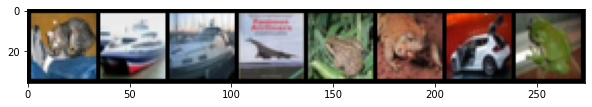

In [43]:
num_epochs = 20
train_loader = train_loader
test_loader = test_loader
model = Net(3072, 200, 10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

model_testing(num_epochs, train_loader, test_loader, model, criterion, optimizer)

В целом показатели улучшились, модель предсказала 6 картинок из 8